In [2]:
%load_ext autoreload
%autoreload 2
import sys
from pathlib import Path
project_root = Path.cwd().parent.parent  # Assuming notebook is in experiments/notebooks/
sys.path.insert(0, str(project_root))
print(sys.path)
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from experiments.analysis_utils.data_processing import read_directory
from experiments.analysis_utils.visualization import plot_reaction_speed_distribution, plot_token_distribution

['/home/rotsker/PycharmProjects/dg-research-revision', '/home/rotsker/miniconda3/envs/radCAD/lib/python312.zip', '/home/rotsker/miniconda3/envs/radCAD/lib/python3.12', '/home/rotsker/miniconda3/envs/radCAD/lib/python3.12/lib-dynload', '', '/home/rotsker/miniconda3/envs/radCAD/lib/python3.12/site-packages']


In [13]:
from model.utils.seed import initialize_seed
from model.utils.reactions import determine_reaction_time_vector
from model.types.reaction_time import ReactionTime, ModeledReactions

def get_actor_category(**kwargs):
    # Get the length of the first boolean numpy array
    first_key = next(iter(kwargs))
    length = len(kwargs[first_key])
    
    # Create an array of strings initialized with a default value
    actor_category = np.array(['Normal'] * length)
    
    # Apply masks to set corresponding names
    for mask_name, mask in kwargs.items():
        actor_category[mask] = mask_name
    
    return actor_category

def get_abstaining_mask(wallet_df):
    actor_typestr = np.array(wallet_df.type)
    abstaining_mask = np.isin(actor_typestr, ['Contract', 'CEX', 'Custody'])
    return abstaining_mask

def get_institutional_mask(wallet_df, institutional_threshold: float = 3000):
    institutional_mask = wallet_df.total >= institutional_threshold
    return institutional_mask

def get_reaction_time_distribution(wallet_df, 
                                   reactions: ModeledReactions = ModeledReactions.Normal,
                                   institutional_threshold: float = 3000):
    reaction_time_vector = determine_reaction_time_vector(len(wallet_df), reactions)

    institutional_mask = get_institutional_mask(wallet_df, institutional_threshold)
    reaction_time_vector[institutional_mask] = ReactionTime.Slow.value

    abstaining_mask = get_abstaining_mask(wallet_df)
    reaction_time_vector[abstaining_mask] = ReactionTime.NoReaction.value

    actor_category = get_actor_category(
        Institutional=institutional_mask,
        Abstaining=abstaining_mask,
    )

    return reaction_time_vector, actor_category

# Distributions

In [4]:
wallet_tuples = [('original', 'stETH token distribution  - stETH+wstETH holders'),
                 ('centralized', 'centralized_wallet_distribution'),
                 ('decentralized', 'decentralized_wallet_distribution')]
wallet_dfs = []
for name, filename in wallet_tuples:
    wallet_df = pd.read_csv(Path('../../data').joinpath(filename + '.csv'))
    wallet_df['distribution'] = name
    wallet_df['total_token_share'] = wallet_df['total'] / wallet_df['total'].sum()
    wallet_dfs.append(wallet_df)
wallet_df_combined = pd.concat(wallet_dfs, ignore_index=True)


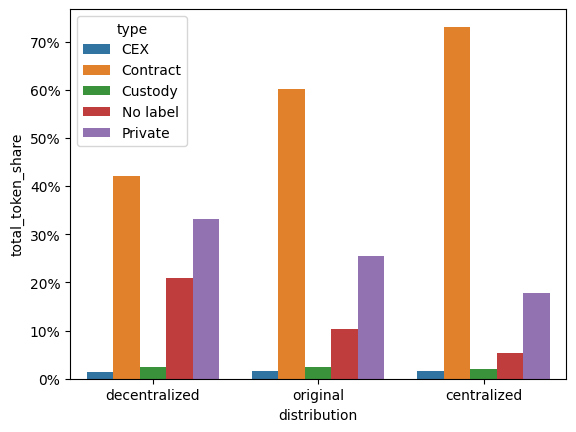

In [17]:
from matplotlib.ticker import PercentFormatter
ax = sns.barplot(
    data=wallet_df_combined.groupby(['distribution', 'type']).total_token_share.sum().reset_index(),
    x='distribution',
    y='total_token_share',
    hue='type',
    order=['decentralized', 'original', 'centralized'])
ax.yaxis.set_major_formatter(PercentFormatter(1))

In [34]:
initialize_seed(100)
for distribution in ['decentralized', 'original', 'centralized']:
    mask = wallet_df_combined.distribution == distribution
    reaction_time_vector, _ = get_reaction_time_distribution(wallet_df_combined[mask], reactions=ModeledReactions.Normal)
    wallet_df_combined.loc[mask, 'reaction_time_vector'] = reaction_time_vector

wallet_df_combined['reaction_time'] = wallet_df_combined['reaction_time_vector'].map(lambda x: ReactionTime(x).name)

Text(0.5, 1.0, 'Average reaction time')

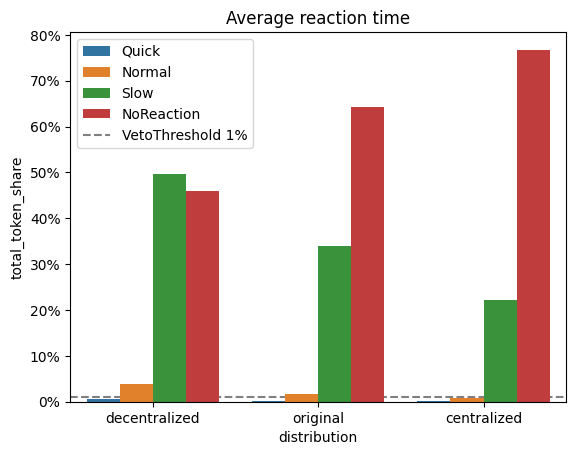

In [35]:
ax =sns.barplot(
    data=wallet_df_combined.groupby(['distribution', 'reaction_time']).total_token_share.sum().reset_index(),
    x='distribution',
    y='total_token_share',
    hue='reaction_time',
    order=['decentralized', 'original', 'centralized'],
    hue_order=['Quick', 'Normal', 'Slow', 'NoReaction'])
ax.yaxis.set_major_formatter(PercentFormatter(1))
xlim = ax.get_xlim()
ax.plot(xlim, [0.01, 0.01], color='gray', linestyle='--', label='VetoThreshold 1%', zorder=0)
ax.set_xlim(xlim)
ax.legend()
ax.set_title('Average reaction time')


Text(0.5, 1.0, 'Average reaction time')

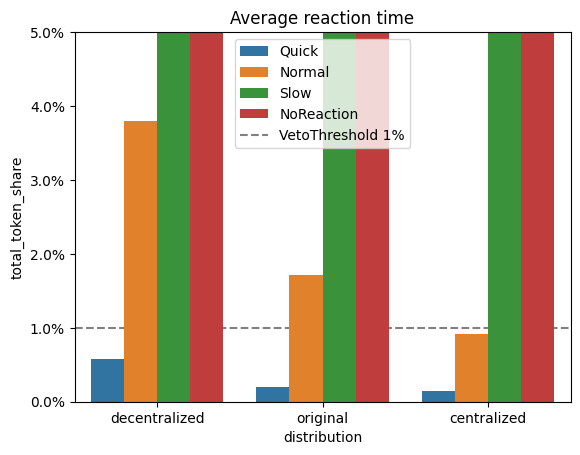

In [36]:
ax = sns.barplot(
    data=wallet_df_combined.groupby(['distribution', 'reaction_time']).total_token_share.sum().reset_index(),
    x='distribution',
    y='total_token_share',
    hue='reaction_time',
    order=['decentralized', 'original', 'centralized'],
    hue_order=['Quick', 'Normal', 'Slow', 'NoReaction'])
ax.yaxis.set_major_formatter(PercentFormatter(1))
ax.set_ylim(0, 0.05)
ax.plot(xlim, [0.01, 0.01], color='gray', linestyle='--', label='VetoThreshold 1%', zorder=0)
ax.set_xlim(xlim)
ax.legend()
ax.set_title('Average reaction time')

# Cluster A

In [8]:
path_to_runs = Path("../../results/simulations/clusterA_future_proof/")
proposal_df_full, start_data_df_full, timestep_data_df_full = read_directory(path_to_runs.resolve(), pass_directory_name=True)
for df in [proposal_df_full, start_data_df_full, timestep_data_df_full]:
    df["wallet_distribution"] = df["directory_name"].str.split("_").str[0]
    df["ModeledReactions"] = df["directory_name"].str.split("_").str[1]


In [9]:
from experiments.analysis_utils.metrics import analyze_veto_timing_by_seals
veto_stats = analyze_veto_timing_by_seals(timestep_data_df_full, start_data_df_full, additional_columns=('wallet_distribution', 'ModeledReactions'))
print("Veto statistics for different wallet distributions and ModeledReactions:")
display(veto_stats)

Veto statistics for different wallet distributions and ModeledReactions:


veto_rate  \
first_seal_rage_quit_support second_seal_rage_quit_support wallet_distribution ModeledReactions              
0.01                         0.1                           centralized         accelerated           100.0   
                                                                               normal                 91.0   
                                                                               slowed                  0.0   
                                                           decentralized       accelerated           100.0   
                                                                               normal                100.0   
                                                                               slowed                100.0   
                                                           original            accelerated           100.0   
                                                                               normal                100.0   
                                                                               slowed                 98.0   

                                                                                                 mean_time_to_veto  \
first_seal_rage_quit_support second_seal_rage_quit_support wallet_distribution ModeledReactions                      
0.01                         0.1                           centralized         accelerated               26.970000   
                                                                               normal                    33.087912   
                                                                               slowed                          NaN   
                                                           decentralized       accelerated                7.480000   
                                                                               normal                    21.180000   
                                                                               slowed                    23.700000   
                                                           original            accelerated               22.320000   
                                                                               normal                    26.000000   
                                                                               slowed                    31.561224   

                                                                                                 median_time_to_veto  \
first_seal_rage_quit_support second_seal_rage_quit_support wallet_distribution ModeledReactions                        
0.01                         0.1                           centralized         accelerated                      27.0   
                                                                               normal                           33.0   
                                                                               slowed                            NaN   
                                                           decentralized       accelerated                       7.0   
                                                                               normal                           21.0   
                                                                               slowed                           24.0   
                                                           original            accelerated                      22.0   
                                                                               normal                           26.0   
                                                                               slowed                           31.0   

                                                                                                 hours_mean_time_to_veto_hours  \
first_seal_rage_quit_support second_seal_rage_quit_support wallet_distribution ModeledReactions                                  
0.01  

In [12]:
timestep_data_df_full_with_params = timestep_data_df_full.merge(start_data_df_full, on='run_id', how='left')
threshold_times = timestep_data_df_full_with_params.groupby('run_id').apply(lambda x: x[x['actors_total_locked_relative'] >= x['second_seal_rage_quit_support']]['timestep'].min()).reset_index(name='threshold_timestep')
threshold_times['threshold_hours'] = threshold_times['threshold_timestep'] * 3
threshold_times = threshold_times.merge(start_data_df_full, on='run_id', how='left')

print("RageQuit threshold times for different wallet distributions and ModeledReactions:")
display(threshold_times.groupby(['first_seal_rage_quit_support', 'second_seal_rage_quit_support', 'wallet_distribution', 'ModeledReactions']).agg({'threshold_hours': ['median', 'min', 'max'], 'run_id': 'count'}))


RageQuit threshold times for different wallet distributions and ModeledReactions:


/tmp/ipykernel_17281/1027194245.py:2: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  threshold_times = timestep_data_df_full_with_params.groupby('run_id').apply(lambda x: x[x['actors_total_locked_relative'] >= x['second_seal_rage_quit_support']]['timestep'].min()).reset_index(name='threshold_timestep')


threshold_hours  \
                                                                                                         median   
first_seal_rage_quit_support second_seal_rage_quit_support wallet_distribution ModeledReactions                   
0.01                         0.1                           centralized         accelerated                234.0   
                                                                               normal                     237.0   
                                                                               slowed                       NaN   
                                                           decentralized       accelerated                198.0   
                                                                               normal                     204.0   
                                                                               slowed                     207.0   
                                                           original            accelerated                219.0   
                                                                               normal                     219.0   
                                                                               slowed                     222.0   

                                                                                                        \
                                                                                                   min   
first_seal_rage_quit_support second_seal_rage_quit_support wallet_distribution ModeledReactions          
0.01                         0.1                           centralized         accelerated       222.0   
                                                                               normal            222.0   
                                                                               slowed              NaN   
                                                           decentralized       accelerated       189.0   
                                                                               normal            195.0   
                                                                               slowed            201.0   
                                                           original            accelerated       204.0   
                                                                               normal            204.0   
                                                                               slowed            207.0   

                                                                                                        \
                                                                                                   max   
first_seal_rage_quit_support second_seal_rage_quit_support wallet_distribution ModeledReactions          
0.01                         0.1                           centralized         accelerated       249.0   
                                                                               normal            249.0   
                                                                               slowed              NaN   
                                                           decentralized       accelerated       207.0   
                                                                               normal            210.0   
                                                                               slowed            213.0   
                                                           original            accelerated       228.0   
                                                                               normal            228.0   
                                                                               slowed            231.0   

                                                                                                run_id  
                                                                

The only problem is that I've ran the simulations where the proposal gets executed, so we don't have the data for slow centralized distributions. Later I can rerun this particular case to get the data. Also normal centralized and slowed original.

# Cluster B

In [23]:
import pandas as pd
from pathlib import Path

# Define the directories and corresponding wallet distribution labels
directories = {
    'withdrawal_queue_replacement_centralized': 'centralized',
    'withdrawal_queue_replacement_decentralized': 'decentralized',
    'withdrawal_queue_replacement_attacker_share_study': 'original'
}

# Initialize empty lists to store each type of DataFrame
proposal_dfs = []
start_data_dfs = []
timestep_data_dfs = []

# Loop through each directory and read the data
max_run_id = 0
for dir_name, distribution_label in directories.items():
    # Construct the path to the directory
    path_to_runs = Path(f"../../results/simulations/{dir_name}/")
    
    # Read the data from the directory
    proposal_df, start_data_df, timestep_data_df = read_directory(path_to_runs.resolve())
    
    # Add the 'wallet_distribution' column to each DataFrame
    proposal_df['wallet_distribution'] = distribution_label
    start_data_df['wallet_distribution'] = distribution_label
    timestep_data_df['wallet_distribution'] = distribution_label
    
    proposal_df['run_id'] = proposal_df['run_id'] + max_run_id
    start_data_df['run_id'] = start_data_df['run_id'] + max_run_id
    timestep_data_df['run_id'] = timestep_data_df['run_id'] + max_run_id
    max_run_id = proposal_df['run_id'].max()
    # Append each DataFrame to its respective list
    proposal_dfs.append(proposal_df)
    start_data_dfs.append(start_data_df)
    timestep_data_dfs.append(timestep_data_df)

# Concatenate each type of DataFrame separately
combined_proposal_df = pd.concat(proposal_dfs, ignore_index=True)
combined_start_data_df = pd.concat(start_data_dfs, ignore_index=True)
combined_timestep_data_df = pd.concat(timestep_data_dfs, ignore_index=True)

Text(0.5, 0, 'Attacker share in the final pool')

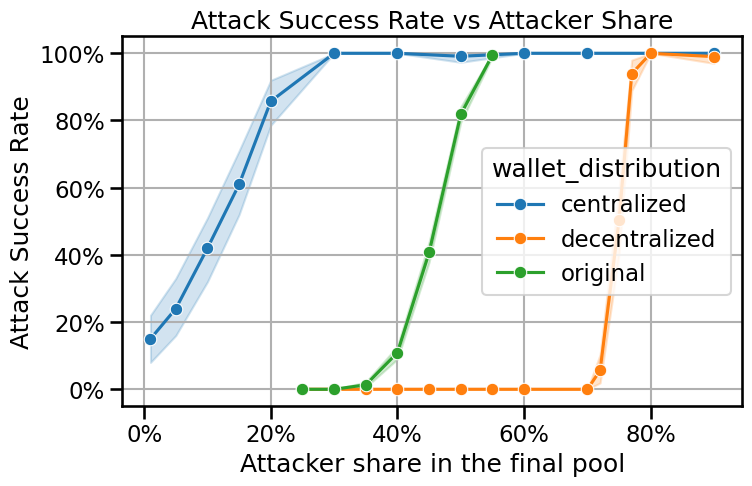

In [40]:
from experiments.analysis_utils.visualization import plot_attack_success_rate
fig = plot_attack_success_rate(combined_timestep_data_df, combined_start_data_df, final_share=True, hue='wallet_distribution')
fig.gca().set_xlabel('Attacker share in the final pool')


(-0.05, 3.5)

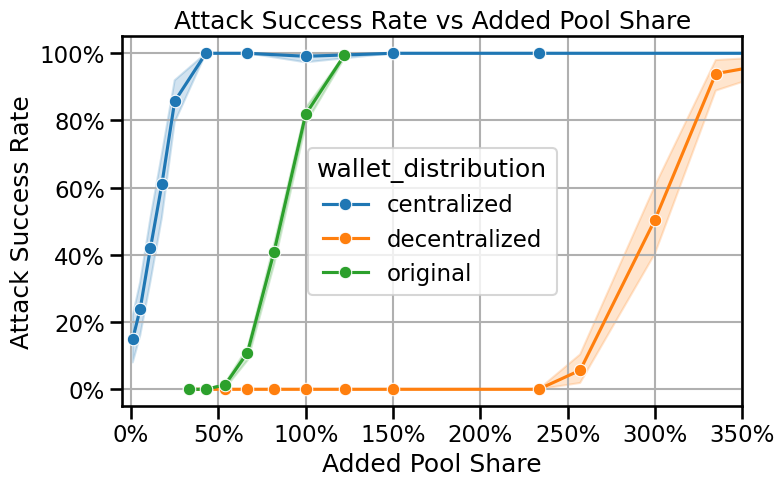

In [41]:
from experiments.analysis_utils.visualization import plot_attack_success_rate
fig = plot_attack_success_rate(combined_timestep_data_df, combined_start_data_df, final_share=False, hue='wallet_distribution')
fig.gca().set_xlim(-0.05, 3.5)


# Larger decentralization 1. (private wallets get richer, number of wallets unchanged)

## Cluster B

In [1]:
# Read the data
path_to_runs = Path("../../results/simulations/withdrawal_queue_replacement_decentralized/")
print(path_to_runs.resolve())
print(path_to_runs.resolve().exists())
proposal_df_full, start_data_df_full, timestep_data_df_full = read_directory(path_to_runs.resolve())




NameError: name 'Path' is not defined

In [78]:
timestep_data_df_full_with_params = timestep_data_df_full.merge(start_data_df_full, on='run_id')

In [85]:
from experiments.analysis_utils.metrics import analyze_veto_timing_by_seals

veto_stats = analyze_veto_timing_by_seals(timestep_data_df_full, start_data_df_full, additional_columns=('attacker_share',))
veto_stats['attack_success_rate'] = 100 - veto_stats['veto_rate']
veto_stats['n_successful_attacks'] = veto_stats['attack_success_rate'] / 100 * veto_stats['total_runs']
veto_stats['pool_share_added_by_attacker'] = veto_stats.index.get_level_values('attacker_share').map(lambda x: x / (1 - x))
print("Veto statistics by seal parameters:")
display(veto_stats)

Veto statistics by seal parameters:


veto_rate  \
first_seal_rage_quit_support second_seal_rage_quit_support attacker_share               
0.01                         0.1                           0.250019        100.000000   
                                                           0.300021        100.000000   
                                                           0.350023        100.000000   
                                                           0.400024        100.000000   
                                                           0.450025        100.000000   
                                                           0.500025        100.000000   
                                                           0.550025        100.000000   
                                                           0.600024        100.000000   
                                                           0.700021        100.000000   
                                                           0.720020         94.339623   
                                                           0.750019         49.494949   
                                                           0.770018          6.060606   
                                                           0.800016          0.000000   
                                                           0.900009          0.000000   

                                                                           mean_time_to_veto  \
first_seal_rage_quit_support second_seal_rage_quit_support attacker_share                      
0.01                         0.1                           0.250019                22.765217   
                                                           0.300021                23.182609   
                                                           0.350023                23.540816   
                                                           0.400024                24.040816   
                                                           0.450025                24.591837   
                                                           0.500025                25.357143   
                                                           0.550025                26.265306   
                                                           0.600024                27.280000   
                                                           0.700021                31.710000   
                                                           0.720020                33.570000   
                                                           0.750019                36.530612   
                                                           0.770018                37.000000   
                                                           0.800016                      NaN   
                                                           0.900009                      NaN   

                                                                           median_time_to_veto  \
first_seal_rage_quit_support second_seal_rage_quit_support attacker_share                        
0.01                         0.1                           0.250019                       23.0   
                                                           0.300021                       23.0   
                                                           0.350023                       23.5   
                                                           0.400024                       24.0   
                                                           0.450025                       25.0   
                                                           0.500025                       25.0   
                                                           0.550025                       26.0   
                                                           0.600024                       27.0   
                                                           0.700021                       31.0   
                                    

We can see that the costs of the attack by diluting the total stETH pool are even higher (the attacker needs to add 3 pools for a 50% chance of successful attack).

## Cluster C. Bribing

In [99]:
path_to_runs = Path("../../results/simulations/bribed_withdrawal_queue_replacement/")
print(path_to_runs.resolve())
print(path_to_runs.resolve().exists())
proposal_df_full, start_data_df_full, timestep_data_df_full = read_directory(path_to_runs.resolve())
print(len(start_data_df_full))

/home/rotsker/PycharmProjects/dg-research-revision/results/simulations/bribed_withdrawal_queue_replacement
True
500


In [100]:
start_data_df_full['early_responders_count'] = start_data_df_full.quick_and_normal_early_responders_count
start_data_df_full['early_responders_tokens'] = start_data_df_full.quick_and_normal_early_responders_stETH_funds + start_data_df_full.quick_and_normal_early_responders_wstETH_funds
total_funds = timestep_data_df_full.groupby('run_id').actors_total_balance.first()
start_data_df_full['early_responders_tokens_relative'] = (
    start_data_df_full['early_responders_tokens'] / 
    start_data_df_full['run_id'].map(total_funds))
start_data_df_full['amount_needed_to_bribe'] = start_data_df_full['early_responders_tokens_relative'] - 0.01

agg_results = start_data_df_full.agg(
    {
        'early_responders_count': ('median', 'min', 'max'),
        'early_responders_tokens_relative': ('median', 'min', 'max'),
        'amount_needed_to_bribe': ('median', 'min', 'max')
    }
)
agg_results = agg_results.clip(lower=0)
agg_results

,early_responders_count,early_responders_tokens_relative,amount_needed_to_bribe
median,237.0,0.039612,0.029612
min,201.0,0.032747,0.022747
max,288.0,0.047873,0.037873


We can see that bribing amount is much higher than in case of original token distribution. It is even higher than with fast reactions.